# **CS 181 HW3 Problem 3**
---

This problem serves as an introduction to building and training machine learning models with PyTorch. This notebook seems long, so here is a breakdown:
- **0) Why PyTorch?** Explains what PyTorch is.
- **1) Initializing tensors**  Explains how we initialize tensors.
- **2) Gradients**  Explains how gradients work.
- **3) MNIST**  Introduces you to a very famous toy dataset.
- **4) Creating a neural network**  Here you create the parameters and architecture of your models from scratch.
- **5) Training a neural network**  Here you create a training loop from scratch.

Parts **0-3** are an introdution to PyTorch. The only deliverables you need to complete are clearly labelled in pars **4-5**. This suffices to replacing `'not implemented'`.

To account for version issues (i.e. if you think your code is right, but you're not getting the right plot), try the following. In your terminal:

1. Create a new environment with `python -m venv venv`
2. Activate that environment with `source venv/bin/activate`
3. Make sure the interpreter in the top right corner of your VSCode (or whatever u use to run ur code is venv).
4. If you get a "install kernel" message, press it.
5. Run `pip install -r requirements.txt`
6. Run the remainder of this notebook.

In [27]:
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from T3_P3_TestCases import test_forward_pass
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## **0) Why PyTorch?**

PyTorch is an open source machine learning framework based on the Torch library. It is currently by far the most popular library for implementing machine learning projects. Unlike in NumPy, PyTorch allows you to perform tensor operations on the GPU. This, alongside dynamic auto-differentiation, makes PyTorch extremely performative and flexible. Learning to use PyTorch will mean you are able to prototype, train, and test production-quality models for work or research.

All the building blocks for machine learning architectures (activation functions, loss functions, neural network layers, etc) are written for you. Exploring everything PyTorch offers takes patience. If you want to and dive further into deep learning, we highly encourage you to read through the [D2L (d2l.ai)](https://d2l.ai/) course, which gives tutorials on how to write even the most state of the art deep learning models from scratch.

## **1) Initializing tensors**

Initializing tensors in PyTorch is analagous to initializing arrays in NumPy. (This is because `torch.Tensor` is a wrapper of `numpy.ndarray`). Below we initialize a tensor with all $0$'s, one with all $1$'s, and one with all random numbers.

In [2]:
n, d = 3, 2

zeroes = torch.zeros(size=(n, d))
print(f'Zeroes:\n{zeroes}')

ones = torch.ones(size=(n, d))
print(f'\nOnes:\n{ones}')

rand = torch.randn(size=(n, d))
print(f'\nRandom:\n{rand}')


Zeroes:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

Ones:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])

Random:
tensor([[-0.8982,  1.1527],
        [-0.4890,  0.1091],
        [-0.4033, -0.8645]])


It seems that `torch.randn` initializes a tensor according to some unknown random distribution. Let's sleuthe out what that distribution might be! First, we can sample this distribution by randomly initializing `n` many $48 \times 64$ matrices (let's call them "images"):

In [9]:
height, width = 48, 64
images = torch.randn(size=(n, height, width))

print(f'Images shape:\t\t{images.shape}')
print(f'First image shape:\t{images[0].shape}')
print(f'Second image shape:\t{images[1].shape}')
print(f'Third image shape:\t{images[2].shape}')

Images shape:		torch.Size([3, 48, 64])
First image shape:	torch.Size([48, 64])
Second image shape:	torch.Size([48, 64])
Third image shape:	torch.Size([48, 64])


Notice that the shape of `images` is `(3, 48, 64)`, meaning $3\times 48 \times 64$. This tensor has 3 axes, or dimensions. The first dimension indexes over all the individual images `images[0]`, `images[1]`, `images[2]`. The second dimension indexes over all the rows in a particular image. The third dimension indexes over the columns in a particular row. This means `images[0][5][2]`, or more cleanly `images[0,5,2]`, gives us the 2nd pixel on the 5th row of the 0th image.

Now that we understand the shape of this `images` object we created, we can visualize the distribution of `torch.randn` by plotting a histogram of the pixel values for each image. To do this, let's flatten our collection of images by flattening the last two dimensions. Since each image is $48 \times 64$, it has $3072$ pixels. Hence, we should see the result `flattened_images` to have the shape `(3, 3072)` and we do.

Interesting! We can visually tell that `torch.randn` samples from the standard normal distribution $\mathcal N(0, 1)$.

Flattened images shape:	torch.Size([3, 3072])


ValueError: The 'color' keyword argument must have one color per dataset, but 3072 datasets and 3 colors were provided

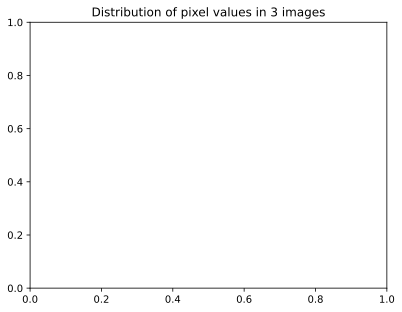

In [11]:
# Assuming `images` is a 4D tensor of shape (n, channels, height, width)
flattened_images = images.flatten(start_dim=1)  # Flatten the images (batch_size, -1)
print(f'Flattened images shape:\t{flattened_images.shape}')

# Plotting the histogram of flattened images' pixel values
plt.title(f'Distribution of pixel values in {len(images)} images')
plt.hist(flattened_images.T, color=('crimson', 'purple','tomato'), bins=50)
plt.xlabel('Pixel value')
plt.ylabel('Frequency')
plt.show()


Flattened images shape:	torch.Size([3, 3072])


ValueError: The 'color' keyword argument must have one color per dataset, but 3072 datasets and 3 colors were provided

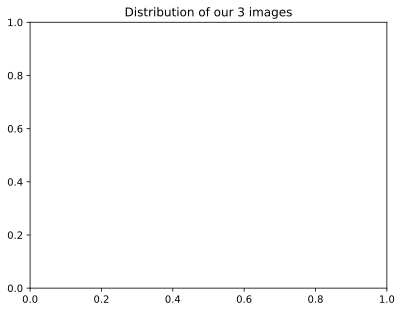

In [7]:
flattened_images = images.flatten(start_dim=1) # or images.reshape(n, -1)
print(f'Flattened images shape:\t{flattened_images.shape}')

plt.title(f'Distribution of our {n} images')
plt.hist(x=flattened_images.T, color=('crimson','purple','tomato'))
plt.plot()

## **2) Gradients**

Numerical operations in PyTorch are almost identical to that in NumPy. However, PyTorch can automatically differentiate operations by backpropogating through a computational graph dynamically produced behind the scenes. This computational graph keeps tracks of the calculations a tensor was part of. It is our responsibility, however, to explicitly tell PyTorch
1. which tensors require gradients,
2. and when to backpropogate to produce a gradient.

For 1. we just need to pass the `requires_grad=True` argument into any of the initialization methods above. However, the `torch.nn.Parameter` class will do this for you for tensors that already exist. We will use this wrapper because it is meant for tensors that represent neural network parameters which will be updated after backpropogation.

For 2. we simply call the `.backward()` API.

In [12]:
f = lambda x: x**3       # define  f(x) = x^3
df = lambda x: 3 * x**2  # define ∇f(x) = 3*x^2 as sanity check

x = torch.tensor(1.0, requires_grad=True)  # initialize x = 1.0
x = torch.nn.Parameter(torch.tensor(1.0))  # this also initializes x = 1.0

y = f(x)      # calculate f(x)
y.backward()  # backpropogate and calculate gradient of f(x) at x = 1.0
print(f'Gradient of f(x) at x = {x}:\t{x.grad}')
print(f'Is this gradient right?:\t{x.grad == df(x)}')

Gradient of f(x) at x = Parameter containing:
tensor(1., requires_grad=True):	3.0
Is this gradient right?:	True


We can even plot the function's derivative over a range to visualize it! Note that before passing our tensors into Matplotlib's `plot`, we must detach them from their gradient information. That is, we want only the underlying tensor. We can do this by `with torch.no_grad()`. If we do not do this, PyTorch will panic since Matplotlib will try to convert the tensor to a NumPy array but cannot because that tensor requires a gradient.

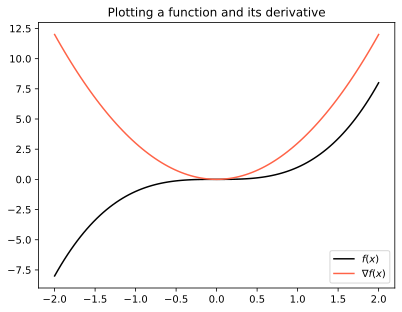

In [13]:
x = torch.linspace(start=-2, end=2, steps=101, requires_grad=True)  # points spread across x-axis

y = f(x)            # calculate y for every point on x-axis
y.sum().backward()  # collapse y into single value in order to calculate the gradient at x value in parrelel

with torch.no_grad():  # specify that we will not want to backpropogate on operations within this block
  plt.plot(x, y, label='$f(x)$', c='k')
  plt.plot(x, x.grad, label=r'$\nabla f(x)$', c='tomato')
plt.title('Plotting a function and its derivative')
plt.legend()
plt.show()


In neural networks, `with torch.no_grad()` is very handy for using our network for prediction or once training is done.

We can also zero out gradients. This is necessary to reset gradients after every round of gradient descent. (Pay attention, because you will be implementing gradient descent). Notice what happens if we don't zero out our gradient:

In [14]:
x = torch.nn.Parameter(torch.tensor(1.0))

y = f(x)
y.backward()
print(f'Gradient of f(x) at x = {x}:\t{x.grad}')

y = f(x)
y.backward()
print(f'Gradient of f(x) at x = {x}:\t{x.grad} (wrong)')

Gradient of f(x) at x = Parameter containing:
tensor(1., requires_grad=True):	3.0
Gradient of f(x) at x = Parameter containing:
tensor(1., requires_grad=True):	6.0 (wrong)


Now notice what happens if we do zero out our gradient:

In [15]:
x = torch.nn.Parameter(torch.tensor(1.0))

y = f(x)
y.backward()
print(f'Gradient of f(x) at x = {x}:\t{x.grad}')

x.grad.zero_()
print(f'Gradient after zero=ing:\t{x.grad}')

y = f(x)
y.backward()
print(f'Gradient of f(x) at x = {x}:\t{x.grad} (right)')


Gradient of f(x) at x = Parameter containing:
tensor(1., requires_grad=True):	3.0
Gradient after zero=ing:	0.0
Gradient of f(x) at x = Parameter containing:
tensor(1., requires_grad=True):	3.0 (right)


## **3) MNIST Dataset**


MNIST is an extremely popular (and non-trivial) example dataset. It consists of $28 \times 28$ black-and-white images of handwritten single digits between 0 and 9. Our goal is to implement and train an MLP to classify these images from scratch.

All the code in this part is written for you, but you should follow each line as you likely need to write these exact (or similar) lines of code multiple times in future research or work.

We define a function below that
1. downloads the MNIST training and test datasets,
2. then wraps each dataset in a "dataloader":

In [17]:
def load_mnist(batch_size):
  trainset = torchvision.datasets.MNIST(root="./data", train=True, transform=torchvision.transforms.ToTensor(), download=True)
  testset = torchvision.datasets.MNIST(root="./data", train=False, transform=torchvision.transforms.ToTensor(), download=True)
  iter_from = lambda dataset: torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
  return iter_from(trainset), iter_from(testset), trainset, testset

mnist_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Let's see how both the dataset and an individual labelled datapoint looks:

In [18]:
train_iter, test_iter, train_set, test_set = load_mnist(batch_size=4)
print(f'Length of training dataset:\t{len(train_set)}')
print(f'Length of test dataset:\t\t{len(test_set)}')

x1, y1 = train_set[0]
y1_text = mnist_labels[y1]
print(f'First datapoint (x_1, y_1):\t(Image: shape {tuple(x1.shape)}, Label: {y1} ({y1_text})),')

Length of training dataset:	60000
Length of test dataset:		10000
First datapoint (x_1, y_1):	(Image: shape (1, 28, 28), Label: 5 (5)),


Notice that each image is $1\times28\times28$: this first dimension represents the different "channels" of the image. In this case, each image is black and white so there is only $1$ channel. However, in other datasets with colored images, we would see red, green, and blue channels: $3\times28\times28$. Another important thing to notice is that the labels are integers $$y_n \in \{0, \ldots, 9\}$$ where $y_n = i$ means the $n$-th image in the dataset corresponds to the clothing item `mnist_labels[i]`.

What is the difference between a dataset and a dataloader? Recall that in a single epoch of stochastic gradient descent, we don't calculate loss on the entire dataset. Instead, within any particular epoch, we iterate over the entire dataset in batches. Dataloaders automatically shuffle and partition the dataset in such a way we can loop over them conviniently in every epoch. Let's look at a single mini batch of size $4$:

Shape of batch X:	 torch.Size([4, 1, 28, 28])
Shape of datapoint x_i:	 torch.Size([1, 28, 28])


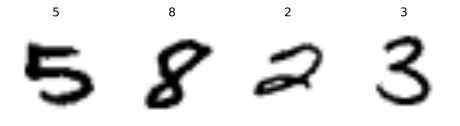

In [19]:
def plot_examples(X, y):
  batch_size = X.shape[0]
  _, axs = plt.subplots(1, batch_size, figsize=(batch_size*2, 2))
  for ax, img, y in zip(axs, X, y):
    ax.imshow(img[0], cmap='binary', interpolation='none')
    ax.set_title(mnist_labels[y]) 
    ax.axis('off')

  
for X, y in train_iter:  # this is how we iterate over the entire training dataset
  batch_shape = X.shape
  print(f'Shape of batch X:\t {batch_shape}')

  data_shape = X[0].shape
  print(f'Shape of datapoint x_i:\t {data_shape}')

  plot_examples(X, y)
  break  # break since it would take 60000/4 = 15000 iterations to finish iterating

## **4) Creating a neural network**

It is now time to implement a multilayer perceptron (MLP) with the following architecture:

\begin{align*}
  \mathbf H &= \operatorname{ReLU}(\mathbf X \mathbf W^{(1)} + \mathbf b^{(1)}) \\
  \mathbf O &= \operatorname{softmax}(\mathbf H \mathbf W^{(2)} + \mathbf b^{(2)}).
\end{align*}

The matrix $\mathbf X \in \mathbb R^{M \times D}$ above corresponds to a minibatch of $M$ datapoints $\mathbf x_i \in \mathbb R^D$. The matrix $\mathbf H \in \mathbb R^{M \times J}$ is the hidden layer. For this problem, we choose the width of the hidden layer to be $J = 256$. The $i$-th row of the output matrix $\mathbf O \in \mathbb R^{M \times K}$ corresponds to the prediction $\hat{\mathbf y} \in \mathbb R^K$ of the $i$-th datapoint. We one hot encode the labels and use a softmax on the last layer so that our MLP models a proper distribution $p(y_n|\mathbf x_n)$. Given an image $\mathbf x^*$, if the $k$-th entry of our output $\hat{\mathbf y}^*$ is the largest, then we predict class $k$. This corresponds to picking the class $y^*$ that maximizes $p(y^* | \mathbf x)$.

![](mlp.svg)

The entirety of implementing this architecture is just implementing the equations above. In order to do this, you will need to
1. **(TODO)** initialize your parameters $\mathbf W^{(1)}, \mathbf b^{(1)}, \mathbf W^{(2)}, \mathbf b^{(2)}$
2. **(TODO)** implement your activation functions $\operatorname{ReLU}$, $\operatorname{softmax}$
3. **(TODO)** implement your forward pass $f(\mathbf X) = \ldots$

Machine learning models can be sensitive to weight initialization. For this architecture, initialize the weights as follows:
\begin{align*}
  \mathbf {W^{(\ell)}}_{i,k} &\sim \mathcal 0.01 \, N(0, 1), \\
  \mathbf {b^{(\ell)}}_{i}\;\,\, &= 0\,.
\end{align*}

*Hint: we just learned initialize random tensors.*

*Double hint: we are flattening each image before feeding it into the MLP. How many inputs nodes in our MLP does this mean?*

*Triple hint: we are one hot encoding our labels. How many dimensions will each label have if there are 10 classes in MNIST?*

In [25]:
"""
We are given images of dimension 28 by 28 and we want to classify them as one of 10 classes (digits 0-9).
At each step, we will be applying a linear transformation (W's) followed by an additive bias term (b's).
We then apply a non-linearity (relu or softmax), which you will be implementing in the cell below.
"""
# 28 by 28
n_inputs = 28 * 28

# hidden units
n_hiddens = 256

# classes for MNIST
n_outputs = 10

W1 = torch.randn(size=(n_inputs, n_hiddens)) * 0.01 # matrix applying linear transformation
W1.requires_grad_()
b1 = torch.zeros(size=(n_hiddens, )) # additive bias term
b1.requires_grad_()
W2 = torch.randn(size=(n_hiddens, n_outputs)) * 0.01 # matrix applying linear transformation
W2.requires_grad_()
b2 = torch.zeros(size=(n_outputs, )) # additive bias term
b2.requires_grad_()

params = [W1, b1, W2, b2]


Activation functions are just as much an aspect of architecture as the number of hidden layers or the network width. Implement
1. **(TODO)** the ReLU function: $$\operatorname{ReLU}(x) = \max(0, x)$$
2. **(TODO)** the softmax function: $$\operatorname{softmax}(\mathbf X)_{ij} = \frac{\exp(\mathbf X_{ij})}{\sum_k \exp \mathbf X_{ik})}.$$

*Hint: See `torch.clamp`.*

In [26]:
def relu(x):
  """
  For each element, set 0 as minimum value and nothing as maximum value. S
  hould not change shape of x.

  :param x: a 2D array of output of first transformation. Shape is (batch_size, n_hiddens)
  :return: a 2D array of output of first non-linearity. Shape is (batch_size, n_hiddens)
  """
  return torch.clamp(x, min=0)

def softmax(X):
  """
  For each row, divide each exponentiated element by the sum of all exponentiated elements in that row. 
  Should not change shape of X.

  :param X: a 2D array of output of second transformation. Shape is (batch_size, n_outputs)
  :return: a 2D array of output of second non-linearity. Shape is (batch_size, n_outputs)
  """
  exp_X = torch.exp(X)
  return exp_X / torch.sum(exp_X, dim=1, keepdim=True)

Now it's time to throw everything together!

1. **(TODOs)** implement the forward pass.

*Hint: The first dimension of `X` indexes over individual images in the batch. We want to flatten the rest of the dimensions.*

*Double hint: Calculate $H$, then Calculate $O$.*

*Triple hint: Like in NumPy, use `@` for matrix multiplication.*

In [28]:
def net(X):
  """
  Implements the forward pass of our neural network. 
  
  :param X: a batch of images of shape (batch_size, 1, 28, 28).
  :return: a 2D array of shape (batch_size, 10) where each row is a probability vector of length 10.
  """
  # Flatten the input images from (batch_size, 1, 28, 28) to (batch_size, 784)
  X = X.flatten(start_dim=1)
  a1 = X @ W1 + b1
  z1 = relu(a1)
  a2 = z1 @ W2 + b2
  z2 = softmax(a2)
  
  return z2

In [29]:
test_forward_pass(net)


Forward pass test passed!


## **5) Training a neural network**



We also need to be able to evaluate our model prediction $\hat {\mathbf y}$ with the true label $\mathbf y$. We can do this through with cross entropy loss. If $K$ is the number of categories we have, then $\hat {\mathbf y}$ is a $K$-dimensional vector of class probabilities computed by softmax, while $\mathbf y$ is a $K$-dimensional one hot vector. With this representation, cross entropy loss is defined as $$\ell(\hat {\mathbf y}, \mathbf y) = -\sum_{k=1}^K \mathbf y_k \log \hat {\mathbf y}_k.$$ Note that since $\mathbf y$ will be all 0 at all indices except its true class (which we denote as $y$), at which it will be 1. Thus, we can much more simply write $$\ell(\hat {\mathbf y}, y) = -\log \hat {\mathbf y}_y.$$

For any general loss function, we can implement the gradient descent update step: $$w \leftarrow w - \eta \, \nabla_w \mathcal L$$ for every model parameter $w$ where $\mathcal L$ is the average loss over the minibatch.

1. **(TODO)** Implement cross entropy loss.
2. **(TODO)** Implement gradient descent.

*Hint: in gradient descent, remember to use `with torch.no_grad():` since we don't want to backpropogate through the update operations.*

*Double hint: assume that the parameters come into `sgd` with their gradients. Hence, $\nabla_w \mathcal L$ is simply `w.grad`.*

*Triple hint: we will need to reset the parameter gradients by zero-ing out at end of gradient descent.*

In [30]:
def cross_entropy(y_hat, y):
  """
  Implement cross entropy loss as defined in the formula above.
  :param y_hat: a 2D array of shape (batch_size, 10) where each row is a probability vector of length 10.
  :param y: a 1D array of shape (batch_size) where each element is a label.

  :return: a 1D array of shape (batch_size) representing the cross entropy losses.
  """
  log_probs = torch.log(y_hat[torch.arange(len(y_hat)), y] + 1e-9)
  loss = -log_probs.mean()
  return loss

def sgd(params, lr=0.1):
  """
  Implements stochastic gradient descent. For each param, subtract the gradient times the learning rate.
  The gradient for each param is stored in param.grad. After updating each param, set its gradient to zero.

  :param params: a list of parameters to update.
  :param lr: the learning rate.

  :return: None
  """
  with torch.no_grad(): 
        for param in params:
            if param.grad is not None:
                param -= lr * param.grad 
                param.grad.zero_()

We finally have all the pieces to train a neural network... except the training loop:

```
  For every epoch:
      For every batch X, y in training dataset:
          1. Calculate y_hat from X
          2. Calculate the losses between y_hat and y
          3. Calculate total loss (the average over all losses)
          4. Backpropagate on the loss
          5. Update parameters with SGD
```

1. **(TODO)** Implement the training loop.

*Hint: Realize that the cross entropy loss we implemented defines loss for a single prediction. The loss over an entire minibatch of size $M$ is actually the average cross entropy loss.*

In [31]:
def train(net, params, train_iter, loss_func=cross_entropy, updater=sgd):
  """
  Implements training loop as described in the 5 steps above.

  :param net: the neural network.
  :param params: the parameters of the neural network.
  :param train_iter: the training data iterator.
  :param loss_func: the loss function.
  :param updater: the function that updates the gradients.

  :return: None
  """
  net.train()  
  for X, y in train_iter:
    y_hat = net(X)
    loss = loss_func(y_hat, y)
    for param in params:
      if param.grad is not None:
        param.grad.zero_()
    loss.backward()
    updater(params)
  
    print(f'Loss: {loss.item()}')
  
  return None


We finished! Sure we can use the training loop above, but how will we know if we are succesfully trianing our model? Tracking training progress is crucial in understanding if changes ought to be made regarding hyperparameters or model architecture. Because of this, we expand the above training loop by adding a few lines that track various metrics such as
1. average train loss
2. average train accuracy
3. average test loss
4. average test accuracy

Note that while this looks much scarier, it can be completely reduced to the much smaller trianing loop above.

In [32]:
epochs = 10
batch_size = 128
lr = 0.1
train_iter, test_iter, _, _ = load_mnist(batch_size=batch_size)


def accuracy(y_hat, y):
  with torch.no_grad():
    y_labels = y_hat.argmax(axis=1)
    correct = y_labels == y
    return correct.sum() / correct.numel()


def train(net, params, train_iter, test_iter, loss, updater):
  train_losses, train_accs = [], []
  test_losses, test_accs = [], []
  
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = 0.0, 0.0
    trials = 0

    for X, y in train_iter:
      trials += 1
      y_hat = net(X)
      l = loss(y_hat, y).mean()
      acc = accuracy(y_hat, y)

      l.backward()
      updater(params, lr)

      train_loss += l
      train_acc += acc

    train_losses.append(train_loss.item() / trials)
    train_accs.append(train_acc.item() / trials)

    test_loss, test_acc = 0.0, 0.0
    trials = 0

    y_pred = []
    y_true = []

    for X, y in test_iter:
      trials += 1
      with torch.no_grad():
        y_hat = net(X)

        # Recording for confusion matrix
        if epoch == epochs-1:
          y_pred += y_hat.argmax(axis=1)
          y_true += y
        
        l = loss(y_hat, y).mean()
        acc = accuracy(y_hat, y)

        test_loss += l
        test_acc += acc
    
    test_losses.append(test_loss.item() / trials)
    test_accs.append(test_acc.item() / trials)
  
  return train_losses, train_accs, test_losses, test_accs, y_pred, y_true

Now, the fruit of our labor, we can train our from-scratch MLP and plot the training metrics. Great work!

In [33]:
train_losses, train_accs, test_losses, test_accs, y_pred, y_true = train(net, params, train_iter, test_iter, loss=cross_entropy, updater=sgd)

100%|██████████| 10/10 [00:42<00:00,  4.25s/it]


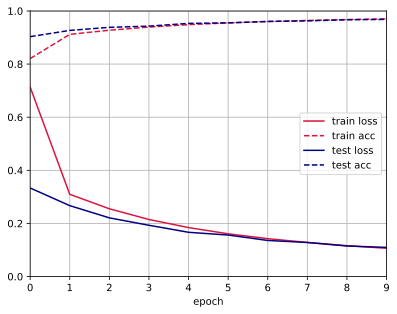

In [34]:
plt.plot(train_losses, c='crimson', label='train loss')
plt.plot(train_accs, '--', c='crimson', label='train acc')
plt.plot(test_losses, c='navy', label='test loss')
plt.plot(test_accs, '--', c='navy', label='test acc')

plt.xlabel('epoch')
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, epochs-1)
plt.legend()
plt.savefig('final_plot.pdf')
plt.show()

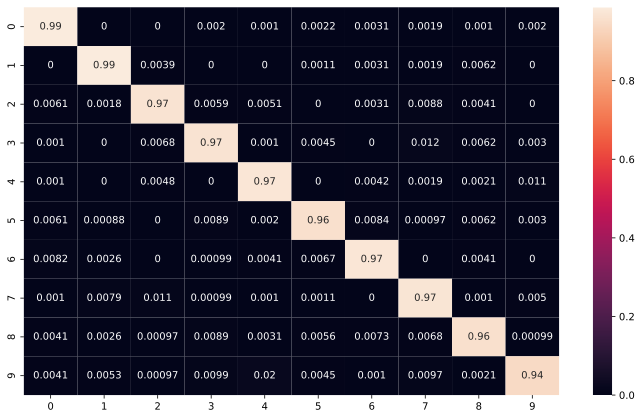

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in mnist_labels],
                     columns = [i for i in mnist_labels])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('confusion_matrix.png')


# Out of Distribution (OOD) Analysis

In [36]:
trainset = torchvision.datasets.MNIST(root="./data", train=True, transform=torchvision.transforms.ToTensor(), download=True)
testset = torchvision.datasets.MNIST(root="./data", train=False, transform=torchvision.transforms.ToTensor(), download=True)

In [37]:
# Constructing our train data to be full of just 1's and 6's
new_train_set = []
for X, y in trainset:
    if y == 1 or y == 6:
        new_train_set.append((X, y))

# Constructing our in-distribution test data to be full of just 1's and 6's
in_test_set = []
for X, y in testset:
    if y == 1 or y == 6:
        in_test_set.append((X, y))

# Constructing our out-of-distribution test data to be full of just 3's
out_test_set = []
for X, y in testset:
    if y == 3:
        out_test_set.append((X, y))

In [38]:
iter_from = lambda dataset: torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, num_workers=2)

train_iter = iter_from(new_train_set)
in_test_iter = iter_from(in_test_set)
out_test_iter = iter_from(out_test_set)

In [42]:
"""Let's re-initialize our parameters. Note that this is the same code as what you have in part 4.1 in this notebook."""

W1 = torch.randn(size=(n_inputs, n_hiddens)) * 0.01  # matrix applying linear transformation
W1.requires_grad_()
b1 = torch.zeros(size=(n_hiddens, )) # additive bias term
b1.requires_grad_()
W2 = torch.randn(size=(n_hiddens, n_outputs)) * 0.01 # matrix applying linear transformation
W2.requires_grad_()
b2 = torch.zeros(size=(n_outputs, )) # additive bias term
b2.requires_grad_()

params = [W1, b1, W2, b2]
params = [W1, b1, W2, b2]

In [40]:
def new_train_test_function(net, params, train_iter, in_test, out_test, loss, updater):
  for _ in tqdm(range(epochs)):
    trials = 0

    for X, y in train_iter:
      trials += 1
      y_hat = net(X)
      l = loss(y_hat, y).mean()

      l.backward()
      updater(params, lr)
  
  # In distribution
  test_acc = 0.0
  trials = 0
  for X, y in in_test:
    trials += 1
    with torch.no_grad():
      y_hat = net(X)
      l = loss(y_hat, y).mean()
      acc = accuracy(y_hat, y)
      test_acc += acc
  
  print("Test Accuracy (In Distribution): " + str(test_acc.item() / trials))
  
  # Out of distribution
  test_acc = 0.0
  trials = 0
  for X, y in out_test:
    trials += 1
    with torch.no_grad():
      y_hat = net(X)
      l = loss(y_hat, y).mean()
      acc = accuracy(y_hat, y)

      test_acc += acc
  
  print("Test Accuracy (Out of Distribution): " + str(test_acc.item() / trials))

In [43]:
new_train_test_function(net, params, train_iter, in_test_iter, out_test_iter, loss=cross_entropy, updater=sgd)

100%|██████████| 10/10 [00:34<00:00,  3.41s/it]


Test Accuracy (In Distribution): 0.9958639705882353
Test Accuracy (Out of Distribution): 0.0
